In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib.colors as colors
import numpy as np

from astropy.visualization import time_support
from astropy.io import fits
from astropy.time import Time
from astropy.wcs import WCS
import astropy.units as u
from astropy.coordinates import EarthLocation, SkyCoord

import glob

from sunpy import timeseries as ts
from sunpy.net import Fido
from sunpy.net import attrs as a
from sunpy.coordinates import frames, sun
import sunpy.map 

import datetime as dt
from datetime import datetime
from datetime import timedelta

# Set up matplotlib
%matplotlib inline

from pylab import rcParams

# Quiet sun subtraction experiment (on the calibrator, Cas A)

### Overview

```mermaid
flowchart LR

A(select data\n quiet sun ) --> B(flagging & calibation\n using CasA & <b>t-dep</b>.)
B --> C(apply sol.\n to quiet sun)
C --> D(create a model from quiet sun\n save-source-component )  
D--> |predict using the model &\n subtract quiet sun from Cas A|B

```

## 1. Modelling the quiet sun 

#### Using ```-save-source-list``` option in WSClean

WSClean supports fitting a polynomial using the joined channel deconvolution method (a **multi-frequency deconvolution** mode). Peak finding is performed in the sum of all channels, allowing deep cleaning, and the PSF is subtracted from each channel & polarization individually, scaled to the value of the peak in that image, which takes care of spectral variation and deconvolves each channel with its own PSF.

--> a weighted MFS image will be generated.

~~~ 
 wsclean -j 40 -mem 80 -auto-mask 3 -auto-threshold 0.3 -fit-beam -make-psf -reorder -multiscale-scales 1,2,4,8,20,40,80 -mgain 0.05 -weight briggs 0 -size 2400 2400 -minuvw-m 500 -maxuvw-m 12000 -scale 10asec -pol I -niter 10000 -join-channels -channels-out 4 -apply-primary-beam -deconvolution-channels 4 -fit-spectral-pol 2 -multiscale-shape gaussian -save-source-list -data-column CORRECTED_DATA -name /net/zernike/scratch3/hgan/processed/L2025886_exp4/case3/sun_model/quiet_sun_model /net/zernike/scratch3/hgan/processed/L2025886_exp4/case3/SB000/Sun_SB000_Cycle0_avg.MS/ /net/zernike/scratch3/hgan/processed/L2025886_exp4/case3/SB001/Sun_SB001_Cycle0_avg.MS/ /net/zernike/scratch3/hgan/processed/L2025886_exp4/case3/SB002/Sun_SB002_Cycle0_avg.MS/ /net/zernike/scratch3/hgan/processed/L2025886_exp4/case3/SB003/Sun_SB003_Cycle0_avg.MS/ /net/zernike/scratch3/hgan/processed/L2025886_exp4/case3/SB004/Sun_SB004_Cycle0_avg.MS/ /net/zernike/scratch3/hgan/processed/L2025886_exp4/case3/SB005/Sun_SB005_Cycle0_avg.MS/  /net/zernike/scratch3/hgan/processed/L2025886_exp4/case3/SB006/Sun_SB006_Cycle0_avg.MS/ /net/zernike/scratch3/hgan/processed/L2025886_exp4/case3/SB007/Sun_SB007_Cycle0_avg.MS/ /net/zernike/scratch3/hgan/processed/L2025886_exp4/case3/SB008/Sun_SB008_Cycle0_avg.MS/  /net/zernike/scratch3/hgan/processed/L2025886_exp4/case3/SB009/Sun_SB009_Cycle0_avg.MS/ 
~~~

--> A quiet sun model is created using the multi-frequency deconvolution method, joining the ***10 lowest frequency channels*** in observation L2025886.


In [2]:
def create_wcsheader_from_fits(file):
    hdu = fits.open(file)
    header = hdu[0].header
    data = hdu[0].data[0, 0, :, :]
    obstime = Time(header['date-obs'])
    frequency = header['crval3']*u.Hz
    wcs = WCS(hdu[0].header)
    return wcs, data, obstime, frequency

### Quiet sun image -- MFS ###

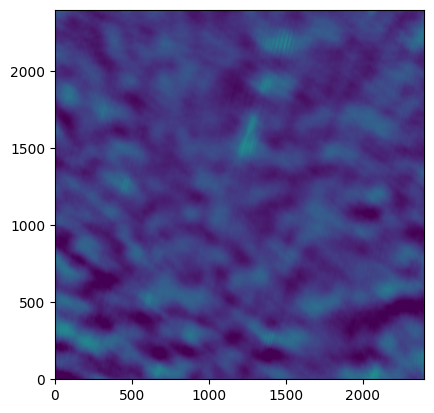

In [44]:
wcs, data, obstime, frequency = create_wcsheader_from_fits('/net/zernike/scratch3/hgan/processed/L2025886_exp4/case3/sun_model/quiet_sun_model-MFS-image-pb.fits')
plt.imshow(data, vmin=-1e4, vmax=5e4, origin='lower')

### Comparison: calibrated quiet sun image (with t-ind. sol.) at t=0 ### 

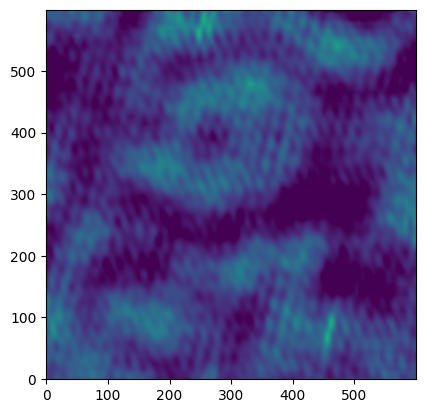

In [43]:
wcs, data, obstime, frequency = create_wcsheader_from_fits('/net/zernike/scratch3/hgan/processed/L2025886_exp1/case3/SB000/images/Sun_Cycle0_avg_CORRECTED_DATA-t0000-image.fits')
plt.imshow(data,  vmin=-1e4, vmax=5e4, origin='lower')

### Clean component quiet sun model ###

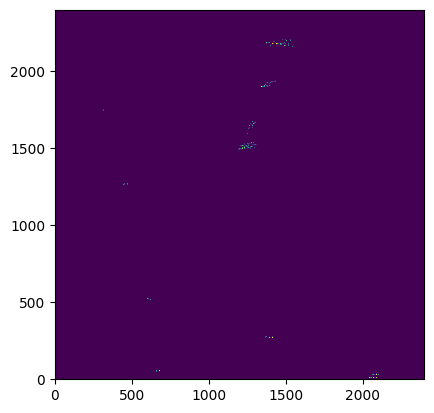

In [46]:
wcs, data, obstime, frequency = create_wcsheader_from_fits('/net/zernike/scratch3/hgan/processed/L2025886_exp4/case3/sun_model/quiet_sun_model-MFS-model-pb.fits')
plt.imshow(data, origin='lower', vmin=1e1, vmax=8e1)

### Quiet sun model 
--> clustered to 3 directions and transformed to a sourcedb format

~~~
Format = Name, Patch, Type, Ra, Dec, I, Q, U, V, SpectralIndex, LogarithmicSI, ReferenceFrequency='150.e6', MajorAxis, MinorAxis, Orientation

, cluster1, POINT, , , , , , , , , , , ,
s0c17, cluster1, POINT, 11:52:47.46, 00.49.22.563, 2293.23901367188, 0, 0, 0, [-913.406127929688], false, 54050676.8526426, , ,
s0c10, cluster1, POINT, 11:52:54.794, 00.48.22.561, 7529.86376953125, 0, 0, 0, [10055.8896484375], false, 54050676.8526426, , ,
s0c15, cluster1, POINT, 11:52:50.794, 00.49.02.562, 7046.13916015625, 0, 0, 0, [3385.88891601562], false, 54050676.8526426, , ,
s0c11, cluster1, POINT, 11:52:54.127, 00.48.32.561, 6012.376953125, 0, 0, 0, [7196.52294921875], false, 54050676.8526426, , ,
s0c14, cluster1, POINT, 11:52:51.46, 00.48.52.562, 2030.70300292969, 0, 0, 0, [1441.08605957031], false, 54050676.8526426, , ,
s0c12, cluster1, POINT, 11:52:53.461, 00.48.42.561, 2268.35400390625, 0, 0, 0, [2029.55700683594], false, 54050676.8526426, , ,
s0c13, cluster1, POINT, 11:52:52.127, 00.48.42.561, 4308.02587890625, 0, 0, 0, [3969.06103515625], false, 54050676.8526426, , ,
s0c16, cluster1, POINT, 11:52:49.46, 00.49.12.562, 3695.67211914062, 0, 0, 0, [522.75927734375], false, 54050676.8526426, , ,
s0c18, cluster1, POINT, 11:52:46.793, 00.49.32.563, 8853.9658203125, 0, 0, 0, [-6605.85009765625], false, 54050676.8526426, , ,
, cluster2, POINT, , , , , , , , , , , ,
s0c5, cluster2, POINT, 11:52:59.461, 00.47.42.559, 2526.48999023438, 0, 0, 0, [5010.51123046875], false, 54050676.8526426, , ,
s0c2, cluster2, POINT, 11:53:01.461, 00.47.32.558, 7585.7890625, 0, 0, 0, [14430.5], false, 54050676.8526426, , ,
s0c8, cluster2, POINT, 11:52:58.128, 00.48.02.559, 1716.0009765625, 0, 0, 0, [2596.35693359375], false, 54050676.8526426, , ,
s0c3, cluster2, POINT, 11:53:00.795, 00.47.32.558, 1944.60095214844, 0, 0, 0, [4093.24291992188], false, 54050676.8526426, , ,
s0c4, cluster2, POINT, 11:53:00.795, 00.47.42.558, 2225.07299804688, 0, 0, 0, [3808.36499023438], false, 54050676.8526426, , ,
s0c6, cluster2, POINT, 11:52:57.461, 00.47.42.56, 4487.81201171875, 0, 0, 0, [12298.650390625], false, 54050676.8526426, , ,
s0c7, cluster2, POINT, 11:52:58.128, 00.47.52.559, 5279.18017578125, 0, 0, 0, [10126.2802734375], false, 54050676.8526426, , ,
s0c9, cluster2, POINT, 11:52:56.128, 00.48.02.56, 4690.966796875, 0, 0, 0, [8464.9072265625], false, 54050676.8526426, , ,
, cluster3, POINT, , , , , , , , , , , ,
s0c1, cluster3, POINT, 11:52:52.126, 00.25.12.551, 5894.61083984375, 0, 0, 0, [-4256.17822265625], false, 54050676.8526426, , ,
s0c0, cluster3, POINT, 11:52:54.126, 00.25.12.55, 7431.7138671875, 0, 0, 0, [-3196.22900390625], false, 54050676.8526426, , ,
~~~

## 2. Predict and subtract the quiet sun 



```mermaid
flowchart LR

A(flagging ) --> B(<b>DDECal</b>\n create t-dep. & d-dep. sol.\n predict visibilities )
B --> C( <b>predict</b>\n subtract the predicted visibilities\n from calibrated Cas A )
C --> D( flagging & imaging )

```


### DP3 Parset setup 
~~~
    cmdstr = "DPPP" + \
             " msin=" + save_dir_SB + calibrator + "_"+SB_Calibrator[i]+"_Cycle0_avg.MS" + \
             " msin.datacolumn=CORRECTED_DATA" + \
             " msout=" + save_dir_SB + calibrator +"_"+SB_Calibrator[i]+"_Cycle1_avg.MS" + \
             " msin.datacolumn=DATA" + \
             " steps=[flag,ddecal]" + \
             " flag.type=madflagger" + \
             " flag.threshold=" + threshold2 + \
             " flag.timewindow=" + timewindow2 + \
             " flag.correlations=[0,3,1,2]" + \
             " ddecal.type=ddecal" + \
             " ddecal.mode=fulljones" + \
             " ddecal.sourcedb=" + model_dir + "sun_model.sourcedb" + \
             " ddecal.directions=[[cluster1],[cluster2],[cluster3]]" + \
		     " ddecal.uvlambdamin=500" + \
	         " ddecal.uvlambdamax=12000" + \
             " ddecal.usebeammodel=true" + \
             " ddecal.smoothnessconstraint=1e6" + \
             " ddecal.nchan=1" + \
             " ddecal.h5parm=" + save_dir_SB + calibrator +"_"+SB_Calibrator[i]+"_Cycle1_avg.h5" + \
             " ddecal.solint=1"

    os.system(cmdstr)


    # Calibration: Apply solution

    cmdstr = "DPPP" + \
        " msin=" + save_dir_SB + calibrator + "_"+SB_Calibrator[i]+"_Cycle1_avg.MS" + \
        " msin.datacolumn=DATA" + \
        " msout=" + save_dir_SB + calibrator + "_"+SB_Calibrator[i]+"_Cycle1_avg.MS" + \
        " msout.datacolumn=CORRECTED_DATA" + \
        " steps=[predict]" + \
        " predict.type=h5parmpredict" + \
        " predict.sourcedb=" + model_dir + "sun_model.sourcedb" + \
        " predict.applycal.parmdb=" + save_dir_SB + calibrator +"_"+SB_Calibrator[i]+"_Cycle1_avg.h5" + \
        " predict.directions=[[cluster1],[cluster2],[cluster3]]" + \
        " predict.usebeammodel=true" + \
        " predict.operation=subtract" + \
        " predict.onebeamperpatch=false" + \
        " predict.applycal.correction=fulljones"
~~~

2025-01-31 15:03:01 - astropy - WARNING: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60208.523611 from DATE-OBS'.


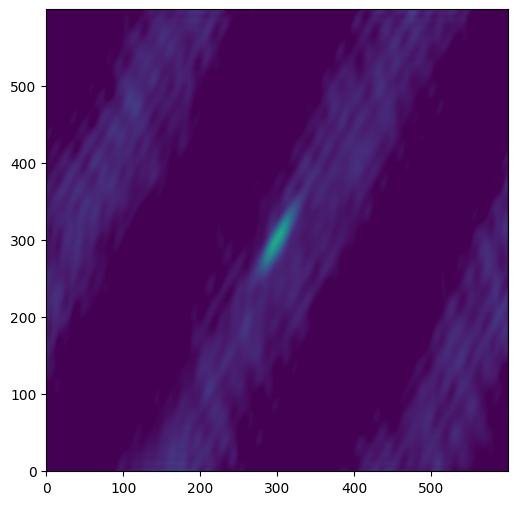

In [106]:
wcs, data, obstime, frequency = create_wcsheader_from_fits('/net/zernike/scratch3/hgan/processed/L2025886_exp4/case3/SB003/images/CasA_Cycle1_avg_CORRECTED_DATA-t0000-image.fits')
plt.imshow(data, vmin=1e2, vmax=3e4, origin='lower')

2025-01-31 15:03:01 - astropy - WARNING: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60208.523613 from DATE-OBS'.


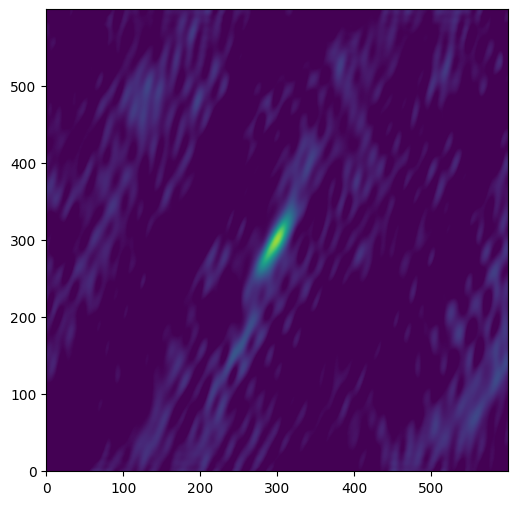

In [107]:
wcs, data, obstime, frequency = create_wcsheader_from_fits('/net/zernike/scratch3/hgan/processed/L2025886_exp2/case3/SB003/images/CasA_Cycle0_avg_CORRECTED_DATA-t0000-image.fits')
plt.imshow(data, vmin=1e2, vmax=3e4, origin='lower')

In [58]:
def create_file_lists( obsID, SB, target, ):
    file_dir = '/net/zernike/scratch3/hgan/processed/'
    infos = file_dir + obsID + SB + '/images/' + target
    MSfiles = [
        infos + '-t0000-image.fits', 
        infos + '-t0001-image.fits', 
        infos + '-t0002-image.fits', 
        infos + '-t0003-image.fits', 
        infos + '-t0004-image.fits', 
   #     infos + '-t0005-image.fits', 
    ]
    return MSfiles 
    
def create_file_lists_freq( obsID, time, target, ):
    file_dir = '/net/zernike/scratch3/hgan/processed/'
    '/net/zernike/scratch3/hgan/processed/L2025886_exp2/case1/SB000/images/Sun_flare_CORRECTED_DATA-t0000-residual.fits'
    infos = file_dir + obsID 
    suffix = '/images/' + target + '-' + time + '-image.fits'
    MSfiles = sorted(glob.glob( infos +'/SB*/' + suffix))
    return MSfiles 

2025-02-03 15:13:49 - astropy - WARNING: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60208.523611 from DATE-OBS'.
2025-02-03 15:13:49 - astropy - WARNING: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60208.523749 from DATE-OBS'.
2025-02-03 15:13:49 - astropy - WARNING: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60208.523889 from DATE-OBS'.
2025-02-03 15:13:50 - astropy - WARNING: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60208.524027 from DATE-OBS'.
2025-02-03 15:13:50 - astropy - WARNING: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60208.524167 from DATE-OBS'.
2025-02-03 15:13:50 - astropy - WARNING: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60208.523613 from DATE-OBS'.
2025-02-03 15:13:50 - astropy - WARNING: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60208.523753 from DATE-OBS'.
2025-02-03 15:13:51 - astropy - WARNING: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS 

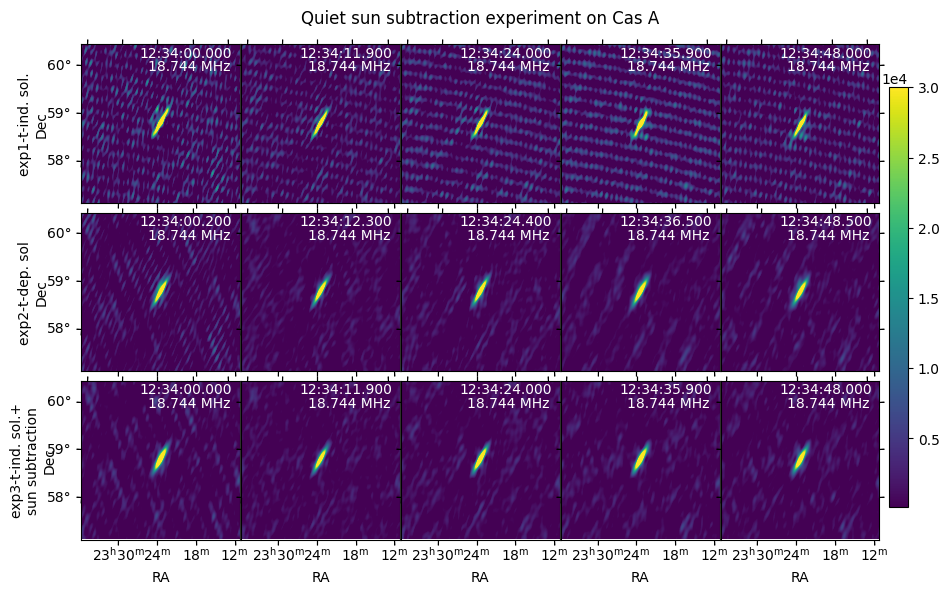

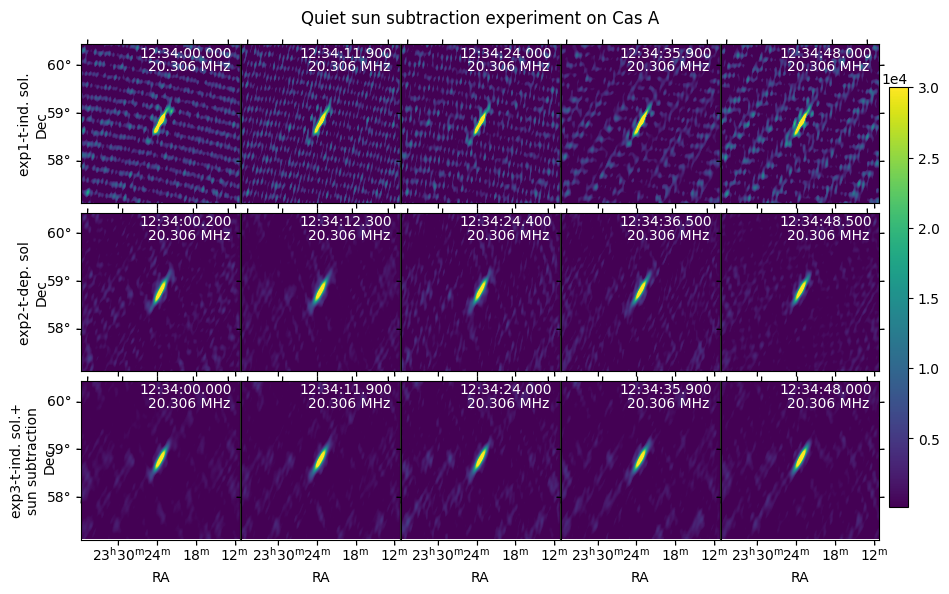

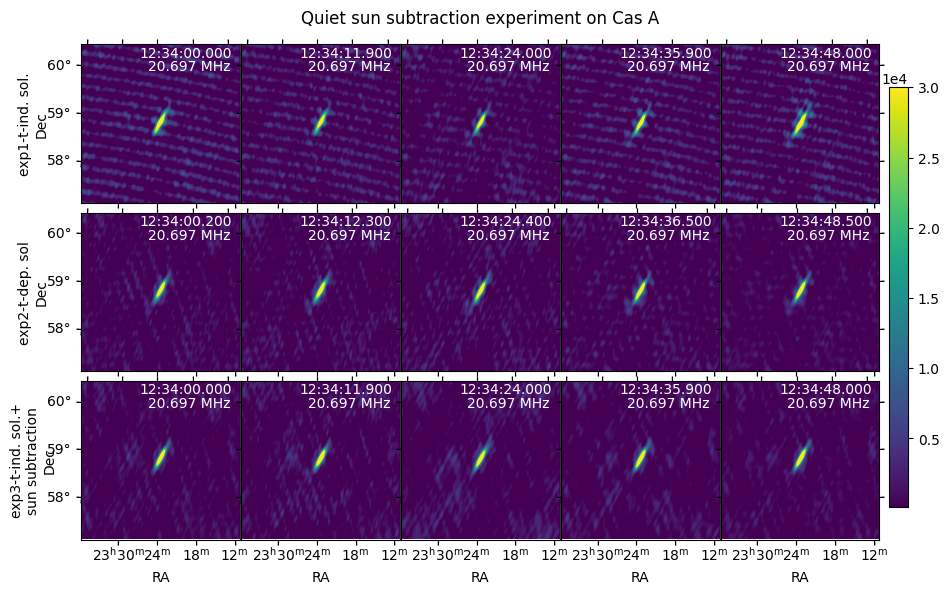

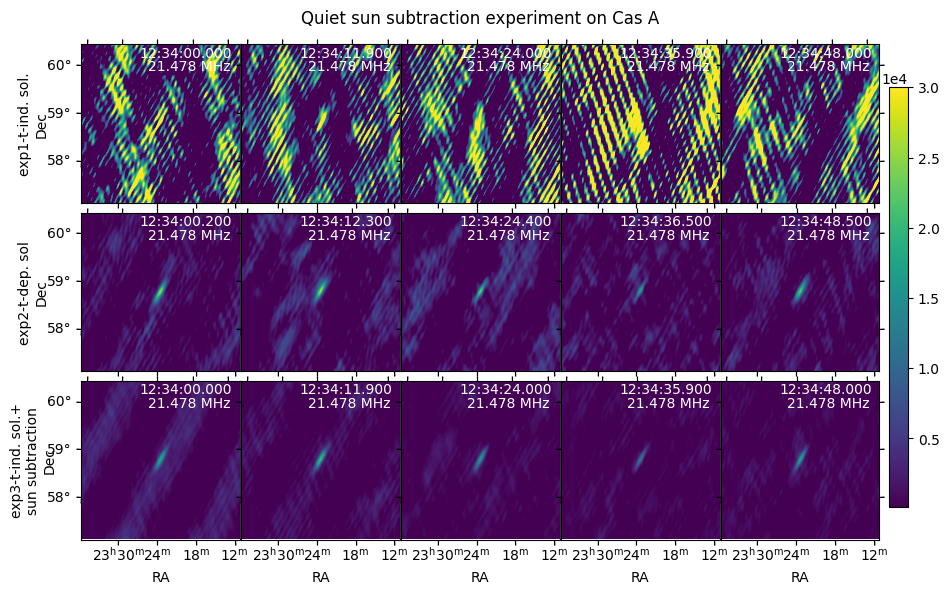

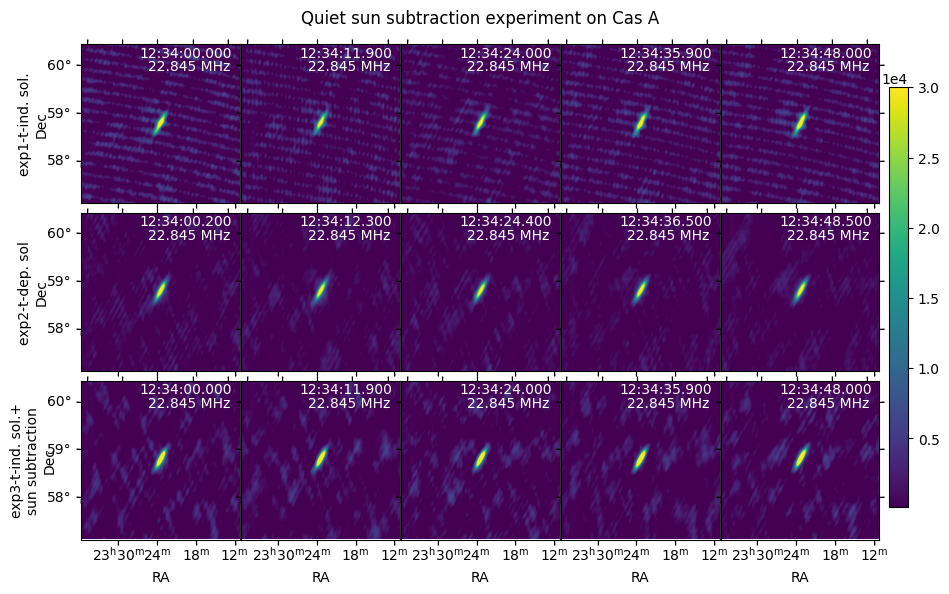

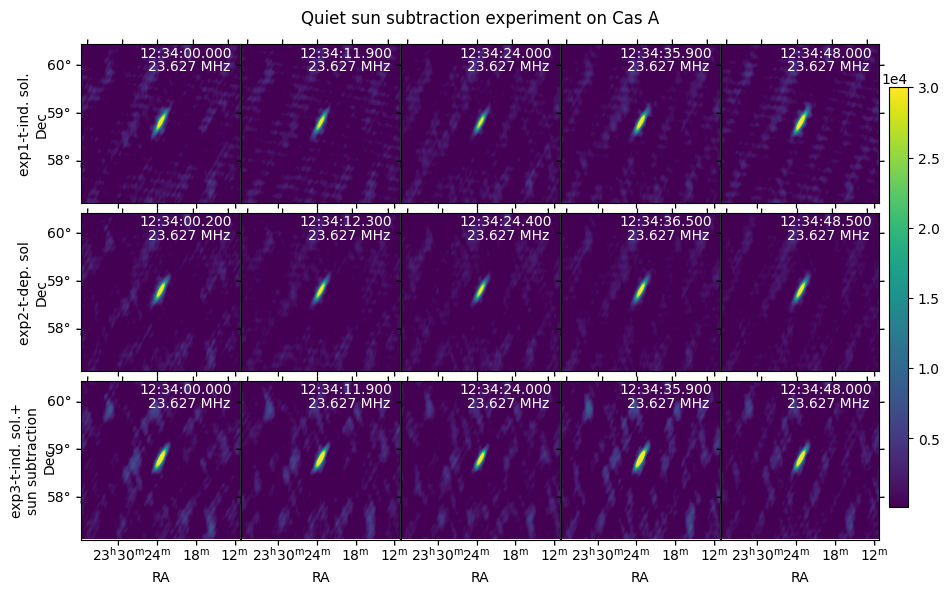

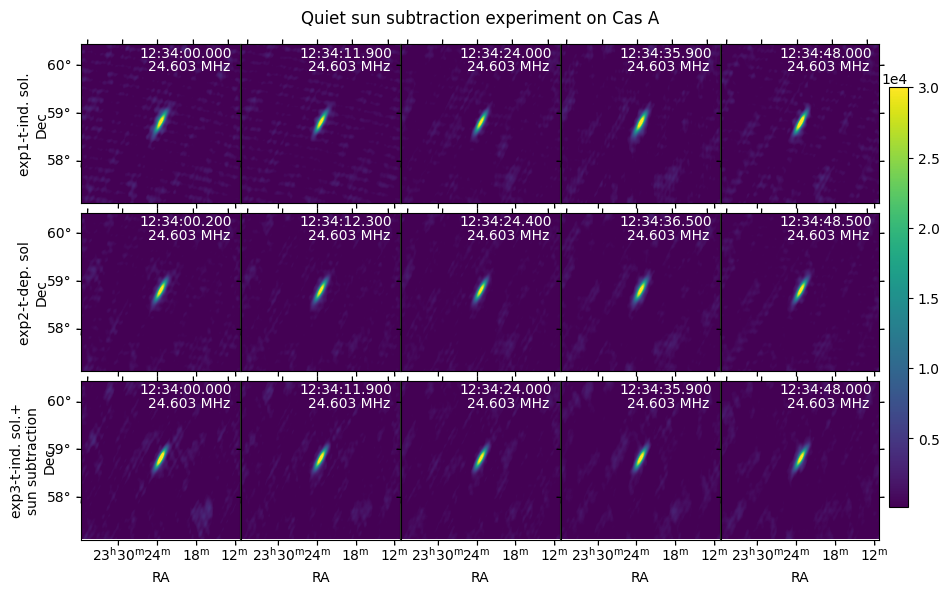

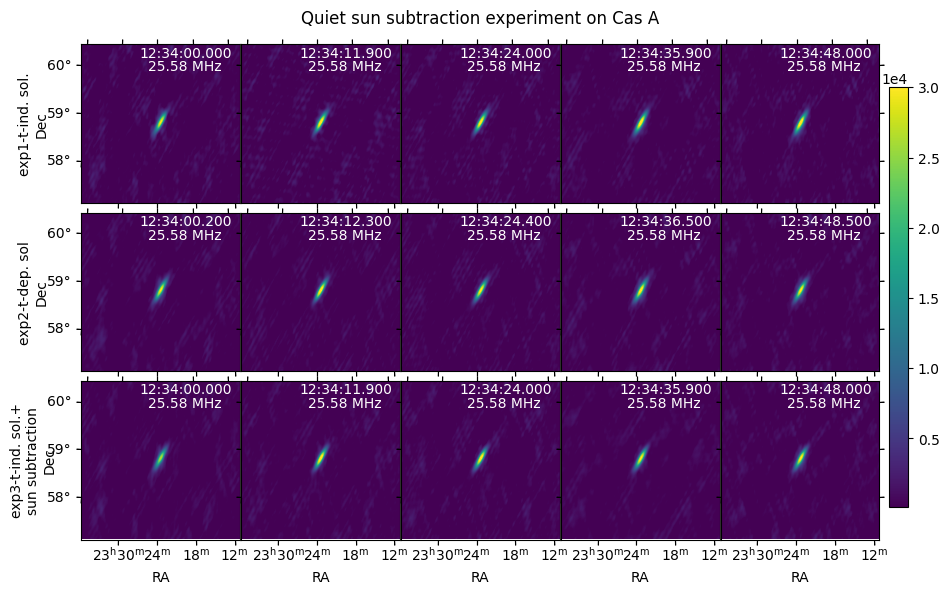

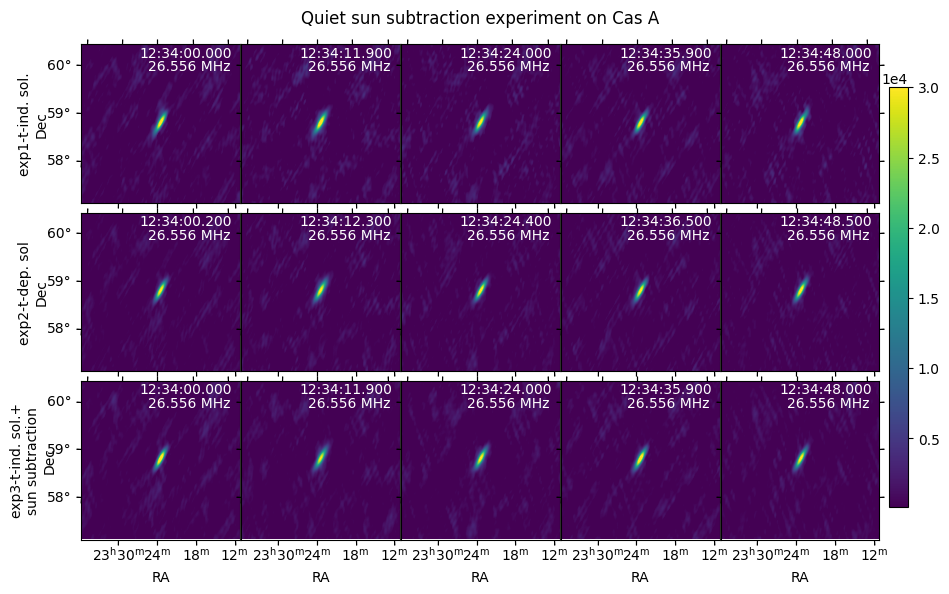

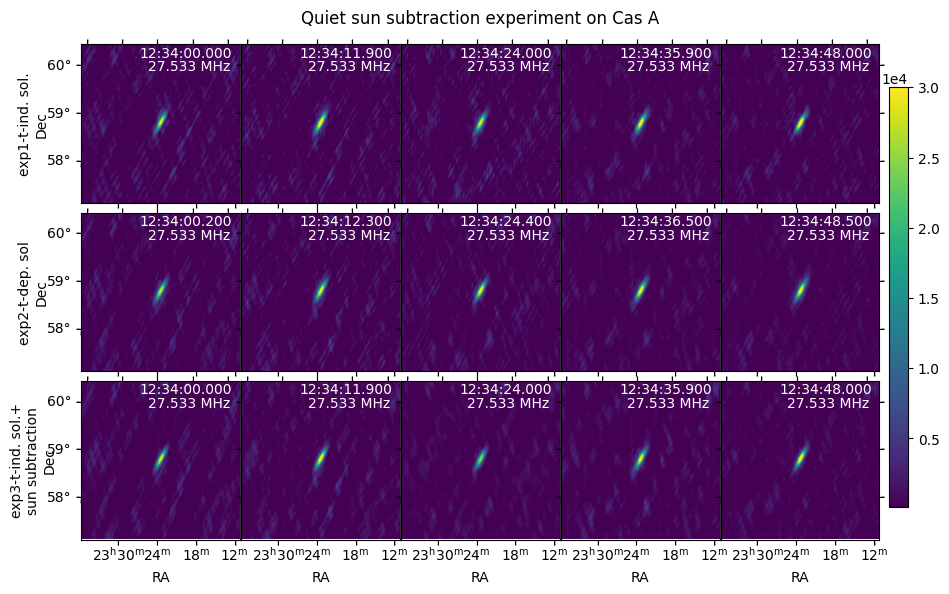

In [121]:
for SB in ['SB000', 'SB001', 'SB002', 'SB003', 'SB004', 'SB005', 'SB006', 'SB007', 'SB008', 'SB009']: 
    rcParams['figure.figsize'] = 9.5, 6.
    fig, axs = plt.subplots(3, 5, subplot_kw=dict(projection=wcs, slices=('x', 'y', 0, 0)) )
    
    exprs = ['L2025886_exp1/case3/', 'L2025886_exp2/case3/', 'L2025886_exp4/case3/']
    titles = ['Case1-before', 'Case2-after', 'Case3-random', 'Case4-before2', 'Case5-after2', ]
    for kk in range(0, len(exprs)):
        MSfiles = create_file_lists( exprs[kk], SB, 'CasA_Cycle0_avg_CORRECTED_DATA', )
        if kk > 1: 
            MSfiles = create_file_lists( exprs[kk], SB, 'CasA_Cycle1_avg_CORRECTED_DATA', )
        for ii in range(0, len(MSfiles)):
            wcs, data, obstime, frequency = create_wcsheader_from_fits(MSfiles[ii])
            #print(MSfiles[ii])
            im = axs[kk,ii].imshow(data, vmin=1e2, vmax=3e4, origin='lower')
            axs[kk,ii].text(220, 550, str(obstime)[-12:], color='white')
            axs[kk,ii].text(250, 500, str(np.round(frequency * 1e-6, 3))[:-2] + 'MHz', color='white')
            # axs[ii].set_title( str(obstime)[-12:-2] +'\n'+ str(np.round(frequency * 1e-6, 3)) + ' MHz', fontsize=10 )
            # axs[ii].grid(color='white', ls='--')
            if ii > 0 : 
                axs[kk,ii].tick_params('y', labelbottom=False)
            # if kk == 0 : 
            #     axs[kk,ii].set_title(titles[ii], y=1.0)
            if kk < 2 : 
                axs[kk,ii].tick_params('x', labelbottom=False)
    
    ylabels = ['exp1-t-ind. sol.\nDec','exp2-t-dep. sol\nDec','exp3-t-ind. sol.+\nsun subtraction\nDec',]
    
    for i, ax in enumerate(axs.flat):
        ax.set_xlabel('RA')
        ax.set_ylabel('Dec')
        ax.label_outer()
    axs[0,0].set_ylabel(ylabels[0])    
    axs[1,0].set_ylabel(ylabels[1])    
    axs[2,0].set_ylabel(ylabels[2])    
    
    fig.suptitle('Quiet sun subtraction experiment on Cas A' ) #\n            Case1 (before)         Case2 (after)            Case3 (quiet) ') 
    fig.subplots_adjust( wspace=0.006, hspace= 0.01, top=.928, left = 0.08, right = 0.92, bottom = 0.09)
    cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.formatter.set_powerlimits((0, 0))
    fig.savefig('exp4-'+SB+'.pdf')

### Calibrated Cas A images after applying t-dep. sol.

## 3. Next steps ##
- improve the quiet sun model:
   - combining fewer / more SBs : cf. currently combining 10 lowest frequency SBs
   - using a modelling methods other than CLEAN?
- optimasation: calibration sol. smoothing / t-interval / number of clusters etc. 
- check calibration solutions
- Comparison: self cal on Cas A